In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm 

from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_log_error,mean_squared_error, make_scorer



In [2]:
#read csv file
df = pd.read_csv('./london_merged.csv',parse_dates = ['timestamp'])

In [3]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [4]:
#check NA values
df.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


In [6]:
#creatinf new columns year,month,day,hour
df["year"] = df["timestamp"].dt.year
df['month'] = df["timestamp"].dt.month
df["dayofweek"] = df["timestamp"].dt.dayofweek
df["hour"] = df["timestamp"].dt.hour


In [7]:
# # replacing blank strings with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cnt,17414.0,1143.101642,1085.108068,0.0,257.0,844.0,1671.75,7860.0
t1,17414.0,12.468091,5.571818,-1.5,8.0,12.5,16.00,34.0
t2,17414.0,11.520836,6.615145,-6.0,6.0,12.5,16.00,34.0
hum,17414.0,72.324954,14.313186,20.5,63.0,74.5,83.00,100.0
wind_speed,17414.0,15.913063,7.894570,0.0,10.0,15.0,20.50,56.5
weather_code,17414.0,2.722752,2.341163,1.0,1.0,2.0,3.00,26.0
is_holiday,17414.0,0.022051,0.146854,0.0,0.0,0.0,0.00,1.0
is_weekend,17414.0,0.285403,0.451619,0.0,0.0,0.0,1.00,1.0
season,17414.0,1.492075,1.118911,0.0,0.0,1.0,2.00,3.0
year,17414.0,2015.507810,0.508157,2015.0,2015.0,2016.0,2016.00,2017.0


<AxesSubplot:>

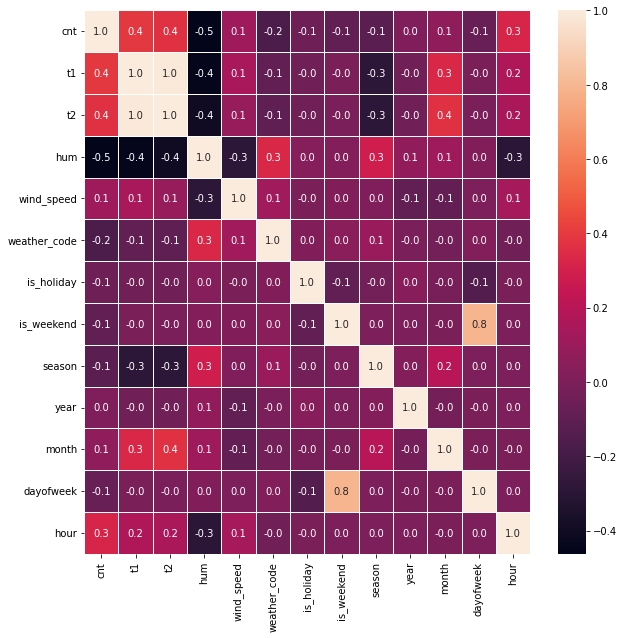

In [9]:
a,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [10]:
#data cleaning
df = df.drop_duplicates()

In [11]:
#outlier treatment
columns = ['cnt', 't1', 't2', 'hum', 'wind_speed']
for col in columns:
    Q3 = df[col].quantile(0.75)
    Q1 = df[col].quantile(0.25)
    Q2 = df[col].quantile(0.50)
    IQR = Q3-Q1
    upper = Q2+(1.5*IQR)
    lower = Q2-(1.5*IQR)
    df = df[(df[col]>lower) & (df[col]<upper)]

In [12]:
#get dummy variables for few columns 
df = pd.get_dummies(df, columns = ['weather_code', 'season','hour','month','dayofweek'], drop_first = True)

In [13]:
#Instantiate an object
scaler = MinMaxScaler()
#Create a list of numeric variables
num_vars=['t1','hum','wind_speed','cnt']
#Fit on data
df[num_vars] = scaler.fit_transform(df[num_vars])
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,is_holiday,is_weekend,year,weather_code_2.0,...,month_9,month_10,month_11,month_12,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,2015-01-04 00:00:00,0.058525,0.108696,2.0,0.861386,0.175439,0.0,1.0,2015,0,...,0,0,0,0,0,0,0,0,0,1
1,2015-01-04 01:00:00,0.043640,0.108696,2.5,0.861386,0.140351,0.0,1.0,2015,0,...,0,0,0,0,0,0,0,0,0,1
4,2015-01-04 04:00:00,0.012855,0.065217,0.0,0.861386,0.192982,0.0,1.0,2015,0,...,0,0,0,0,0,0,0,0,0,1
5,2015-01-04 05:00:00,0.012517,0.065217,2.0,0.861386,0.105263,0.0,1.0,2015,0,...,0,0,0,0,0,0,0,0,0,1
6,2015-01-04 06:00:00,0.014208,0.021739,-1.0,1.000000,0.210526,0.0,1.0,2015,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cnt,13979.0,0.286916,0.252515,0.0,0.060217,0.226319,0.438092,1.0
t1,13979.0,0.486551,0.219609,0.0,0.326087,0.500000,0.652174,1.0
t2,13979.0,10.669385,6.155921,-3.5,5.500000,12.000000,15.500000,23.5
hum,13979.0,0.518263,0.226682,0.0,0.356436,0.544554,0.693069,1.0
wind_speed,13979.0,0.478301,0.228754,0.0,0.280702,0.456140,0.649123,1.0
is_holiday,13979.0,0.024108,0.153389,0.0,0.000000,0.000000,0.000000,1.0
is_weekend,13979.0,0.297518,0.457183,0.0,0.000000,0.000000,1.000000,1.0
year,13979.0,2015.512769,0.509635,2015.0,2015.000000,2016.000000,2016.000000,2017.0
weather_code_2.0,13979.0,0.217755,0.412735,0.0,0.000000,0.000000,0.000000,1.0
weather_code_3.0,13979.0,0.212032,0.408762,0.0,0.000000,0.000000,0.000000,1.0


In [15]:
df_final = df.drop(columns=['timestamp','year','t2'])

In [16]:
df_final.columns

Index(['cnt', 't1', 'hum', 'wind_speed', 'is_holiday', 'is_weekend',
       'weather_code_2.0', 'weather_code_3.0', 'weather_code_4.0',
       'weather_code_7.0', 'weather_code_10.0', 'weather_code_26.0',
       'season_1.0', 'season_2.0', 'season_3.0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4',
       'dayofweek_5', 'dayofweek_6'],
      dtype='object')

In [17]:
X = df_final.loc[:, df_final.columns != 'cnt']
y = df_final.loc[:, df_final.columns == 'cnt']

In [18]:
lm = LinearRegression()
rfe = RFE(lm, n_features_to_select=20)
rfe = rfe.fit(X, y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True False False  True False False False False False False  True
  True  True False False False False False False  True False False False
 False False False False False False  True  True False False False False
 False False  True  True  True  True  True  True  True  True  True False
 False False False False  True  True]
[ 1  1 20 19  1 27 33 34 18 12 25  1  1  1 26 23 22 21 24 16  1 13  2 10
  9  6  5  8  7  3  1  1  4 11 14 15 17 32  1  1  1  1  1  1  1  1  1 35
 31 29 28 30  1  1]


In [19]:
for i in range(X.shape[1]):
    
    print('Column: %s, Selected %s, Rank: %.3f' % (X.columns.to_list()[i], rfe.support_[i], rfe.ranking_[i]))

Column: t1, Selected True, Rank: 1.000
Column: hum, Selected True, Rank: 1.000
Column: wind_speed, Selected False, Rank: 20.000
Column: is_holiday, Selected False, Rank: 19.000
Column: is_weekend, Selected True, Rank: 1.000
Column: weather_code_2.0, Selected False, Rank: 27.000
Column: weather_code_3.0, Selected False, Rank: 33.000
Column: weather_code_4.0, Selected False, Rank: 34.000
Column: weather_code_7.0, Selected False, Rank: 18.000
Column: weather_code_10.0, Selected False, Rank: 12.000
Column: weather_code_26.0, Selected False, Rank: 25.000
Column: season_1.0, Selected True, Rank: 1.000
Column: season_2.0, Selected True, Rank: 1.000
Column: season_3.0, Selected True, Rank: 1.000
Column: hour_1, Selected False, Rank: 26.000
Column: hour_2, Selected False, Rank: 23.000
Column: hour_3, Selected False, Rank: 22.000
Column: hour_4, Selected False, Rank: 21.000
Column: hour_5, Selected False, Rank: 24.000
Column: hour_6, Selected False, Rank: 16.000
Column: hour_7, Selected True, Ra

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [25]:
# Running the linear model 
lm = sm.OLS(y_train,X_train).fit()

In [26]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     578.7
Date:                Sun, 08 May 2022   Prob (F-statistic):               0.00
Time:                        20:02:04   Log-Likelihood:                 6682.4
No. Observations:               11183   AIC:                        -1.326e+04
Df Residuals:                   11132   BIC:                        -1.289e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
t1                    0.1982      0.01

In [27]:
X = X.drop(columns = ['weather_code_3.0','weather_code_4.0','weather_code_26.0','month_2','month_12','dayofweek_5'])

In [28]:
X.columns

Index(['t1', 'hum', 'wind_speed', 'is_holiday', 'is_weekend',
       'weather_code_2.0', 'weather_code_7.0', 'weather_code_10.0',
       'season_1.0', 'season_2.0', 'season_3.0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'dayofweek_1',
       'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_6'],
      dtype='object')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [30]:
# Running the linear model 
lm = sm.OLS(y_train,X_train).fit()

In [31]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     642.5
Date:                Sun, 08 May 2022   Prob (F-statistic):               0.00
Time:                        20:02:07   Log-Likelihood:                 6677.6
No. Observations:               11183   AIC:                        -1.326e+04
Df Residuals:                   11137   BIC:                        -1.293e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
t1                    0.1914      0.01

In [32]:
#Select and train model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [33]:
from sklearn.metrics import mean_squared_error
y_predictions = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, y_predictions)
lin_rmse = np.sqrt(lin_mse)
print("Mean Squared Error = ",lin_mse)
print("Root Mean Squared Error = ",lin_rmse)

Mean Squared Error =  0.019039323765361476
Root Mean Squared Error =  0.13798305608067055


D:\New folder\envs\rstudio-\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


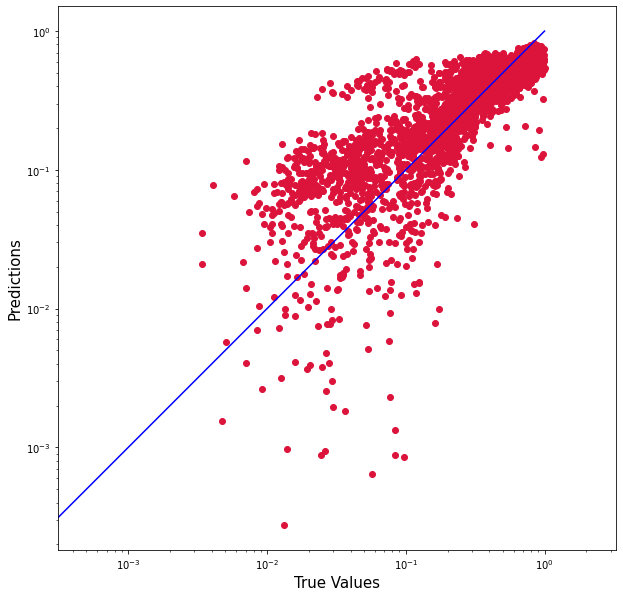

In [34]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_predictions, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_predictions), max(y_test['cnt']))
p2 = min(min(y_predictions), min(y_test['cnt']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()


In [35]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [36]:
y_predictions = tree_reg.predict(X_test)
tree_mse = mean_squared_error(y_test, y_predictions)
tree_rmse = np.sqrt(tree_mse)
print("Mean Squared Error = ",tree_mse)
print("Root Mean Squared Error = ",tree_rmse)

Mean Squared Error =  0.011384967021665632
Root Mean Squared Error =  0.10670036092565775


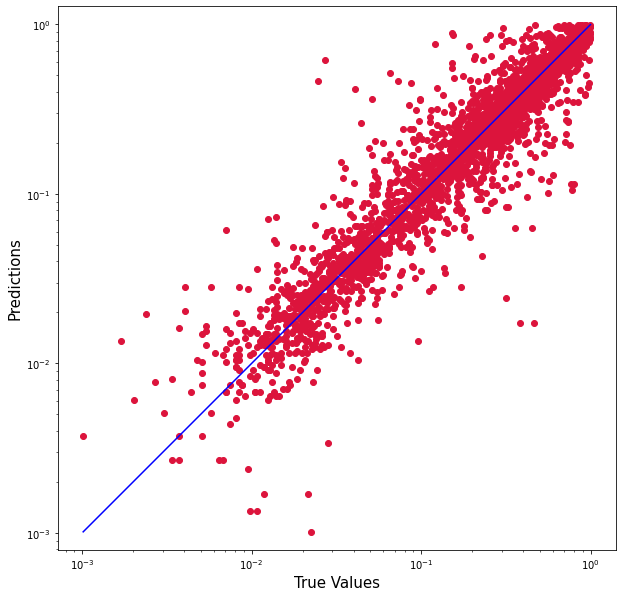

In [37]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_predictions, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_predictions), max(y_test['cnt']))
p2 = min(min(y_predictions), min(y_test['cnt']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()
